<a href="https://colab.research.google.com/github/praymesh/VLM-SEGMENTATION/blob/main/Visual_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from transformers import AutoProcessor, AutoModel
from PIL import Image
import numpy as np


Comparision of Sg1 and Sg2 : https://huggingface.co/spaces/google/zero-shot-sg1-sg2\

SigLIP 2 is pre-trained on the WebLI dataset (Chen et al., 2023).
Model Used as of Now : google/siglip2-base-patch16-224-jax : https://huggingface.co/google/siglip2-base-patch16-224-jax

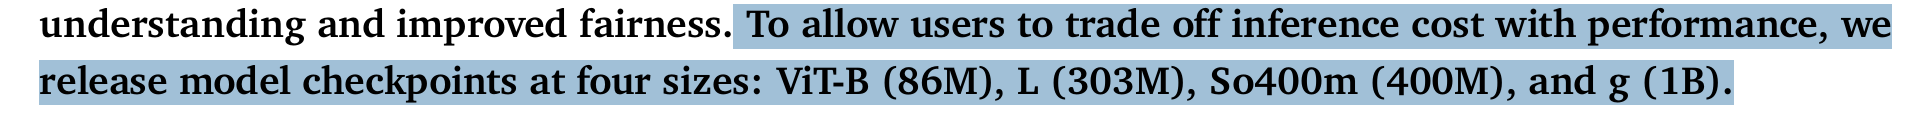

In [ ]:
# ! pip install ipywidgets #vs code

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.2 MB 5.6 MB/s eta 0:00:01
   ------------------- -------------------- 1.0/2.2 MB 2.4 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.2 MB 2.3 MB/s eta 0:00:01
   --------------------------------- ------ 1.8/2.2 MB 2.0 MB/s eta 0:00:01
   --------------------------------- ------ 1.8/2.2 MB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 1.6 MB/s eta 0:00:00


In [ ]:
# huggngface auth

from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# replacing CLIP with SIGLIP 2, We Will use the Base Model
model_name = "google/siglip2-base-patch16-224-jax"
processor = AutoProcessor.from_pretrained(model_name)
siglip2 = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

KeyboardInterrupt: 

# INPUT IMAGE PROCESSING/Loading DATASET :


In [1]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T


In [2]:
# from https://github.com/nightrome/cocostuff/blob/master/README.md#setup
# Get this repo
!git clone https://github.com/nightrome/cocostuff.git
!cd cocostuff

# Download everything
!wget --directory-prefix=downloads http://images.cocodataset.org/zips/train2017.zip
!wget --directory-prefix=downloads http://images.cocodataset.org/zips/val2017.zip
!wget --directory-prefix=downloads http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip

# Unpack everything
!mkdir -p dataset/images
!mkdir -p dataset/annotations
!unzip downloads/train2017.zip -d dataset/images/
!unzip downloads/val2017.zip -d dataset/images/
!unzip downloads/stuffthingmaps_trainval2017.zip -d dataset/annotations/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/annotations/val2017/000000222235.png  
  inflating: dataset/annotations/val2017/000000038678.png  
  inflating: dataset/annotations/val2017/000000189698.png  
  inflating: dataset/annotations/val2017/000000208363.png  
 extracting: dataset/annotations/val2017/000000572956.png  
  inflating: dataset/annotations/val2017/000000384513.png  
 extracting: dataset/annotations/val2017/000000471893.png  
 extracting: dataset/annotations/val2017/000000302536.png  
  inflating: dataset/annotations/val2017/000000531036.png  
  inflating: dataset/annotations/val2017/000000087038.png  
  inflating: dataset/annotations/val2017/000000488736.png  
  inflating: dataset/annotations/val2017/000000012120.png  
  inflating: dataset/annotations/val2017/000000341196.png  
  inflating: dataset/annotations/val2017/000000470779.png  
  inflating: dataset/annotations/val2017/000000397303.png  
 extracting: dataset/annotations/val2017/00000039

In [3]:
# prompt: check the size and stucture of dataset

# Check the size of the dataset directories
!du -sh dataset/images/train2017
!du -sh dataset/images/val2017
!du -sh dataset/annotations/stuffthingmaps_trainval2017

# Count the number of files in each directory (basic structure check)
!ls dataset/images/train2017 | wc -l
!ls dataset/images/val2017 | wc -l
!ls dataset/annotations/stuffthingmaps_trainval2017 | wc -l

# List a few files from each directory to see the naming convention (basic structure check)
!ls dataset/images/train2017 | head -n 5
!ls dataset/images/val2017 | head -n 5
!ls dataset/annotations/stuffthingmaps_trainval2017 | head -n 5


19G	dataset/images/train2017
788M	dataset/images/val2017
du: cannot access 'dataset/annotations/stuffthingmaps_trainval2017': No such file or directory
118287
5000
ls: cannot access 'dataset/annotations/stuffthingmaps_trainval2017': No such file or directory
0
000000000009.jpg
000000000025.jpg
000000000030.jpg
000000000034.jpg
000000000036.jpg
000000000139.jpg
000000000285.jpg
000000000632.jpg
000000000724.jpg
000000000776.jpg
ls: cannot access 'dataset/annotations/stuffthingmaps_trainval2017': No such file or directory


In [ ]:
# prompt: Help me save the dataset in my drive so that i dont  need to aceess everytime ,

from google.colab import drive
drive.mount('/content/drive')

# Create target directories in Google Drive
!mkdir -p /content/drive/MyDrive/coco_dataset/images
!mkdir -p /content/drive/MyDrive/coco_dataset/annotations

# Move the downloaded and unpacked dataset files to Google Drive
!mv dataset/images/* /content/drive/MyDrive/coco_dataset/images/
!mv dataset/annotations/* /content/drive/MyDrive/coco_dataset/annotations/

print("Dataset saved to Google Drive at /content/drive/MyDrive/coco_dataset/")


Mounted at /content/drive


In [ ]:
# prompt: Help me visualise this coc stuff dataset ,

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Assuming the dataset is now in Google Drive as specified in the previous code
image_dir = '/content/drive/MyDrive/coco_dataset/images/train2017'
annotation_dir = '/content/drive/MyDrive/coco_dataset/annotations/stuffthingmaps_trainval2017/train2017'

# Get a list of image and annotation files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith('.png')]

# We'll visualize the first few images with their annotations
num_examples_to_visualize = 5

print(f"Visualizing the first {num_examples_to_visualize} examples from the dataset...")

for i in range(min(num_examples_to_visualize, len(image_files))):
    img_filename = image_files[i]
    # The annotation filename should match the image filename but with a different extension
    # We need to strip the extension and add the annotation extension
    img_basename = os.path.splitext(img_filename)[0]
    annotation_filename = f"{img_basename}.png"

    img_path = os.path.join(image_dir, img_filename)
    annotation_path = os.path.join(annotation_dir, annotation_filename)

    if os.path.exists(img_path) and os.path.exists(annotation_path):
        try:
            img = mpimg.imread(img_path)
            annotation = mpimg.imread(annotation_path)

            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Image: {img_filename}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            # Annotation maps are often single channel (grayscale) or have an alpha channel.
            # We'll display the annotation map. You might need to adjust the colormap
            # or how you display it depending on the specific annotation format (e.g., for semantic segmentation)
            plt.imshow(annotation, cmap='viridis') # Use a colormap to better visualize different values
            plt.title(f"Annotation: {annotation_filename}")
            plt.axis('off')

            plt.show()

        except Exception as e:
            print(f"Error visualizing {img_filename} or {annotation_filename}: {e}")
    else:
        print(f"Could not find matching image or annotation file for {img_filename}")

print("Visualization complete.")


In [ ]:
# Method 2 : Download the dataset via shell (Colab) #from COC stu
!mkdir -p coco2017/images
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip -q train2017.zip -d coco2017/images

!mkdir -p coco2017/annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip -d coco2017/annotations


In [1]:
from torchvision.datasets import CocoDetection
dataset = CocoDetection(
    root='/content/coco2017/images/train2017',
    annFile='/content/coco2017/annotations/instances_train2017.json',
    transform=T.ToTensor()
)

SyntaxError: incomplete input (ipython-input-1-3420494280.py, line 5)

In [ ]:

class SIGLIPSeg(torch.nn.Module):
    def __init__(self, siglip_model, hidden_size=1024):
        super().__init__()
        self.vision_model = siglip_model.vision_model
        self.text_model = siglip_model.text_model
        self.mask_decoder = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=4, mode='bilinear'),
            torch.nn.Conv2d(256, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 64, 3, padding=1),
            torch.nn.Upsample(scale_factor=4, mode='bilinear')
        )

    def forward(self, pixel_values, text_tokens):
        # Extract image features
        vision_output = self.vision_model(pixel_values=pixel_values)
        image_embeds = vision_output.last_hidden_state[:, 1:]  # Remove CLS token

        # Extract text features
        text_output = self.text_model(input_ids=text_tokens)
        text_embeds = text_output.last_hidden_state[:, 0]  # CLS token

        # Reshape to spatial dimensions
        h = w = int(image_embeds.shape[1]**0.5)
        image_embeds = image_embeds.permute(0, 2, 1).view(-1, 1024, h, w)

        # Fuse features (element-wise multiplication)
        fused = image_embeds * text_embeds.unsqueeze(-1).unsqueeze(-1)

        # Generate masks
        masks = self.mask_decoder(fused)
        return masks